In [1]:
# dataset
def read_ner_txt(path, test_mode=False):
    with open(path, 'r', encoding='utf-8') as f:
        text = [i.strip() for i in f.readlines()]
    
    tokens_list = []
    ner_tags_list = []
    temp_vocab = ''
    temp_label = ''

    if test_mode:
        print('test mode')
        for item in text:
            if item == '.' or item == '':
                if item == '.':
                    temp_vocab += ' ' + item
                    temp_label += ' ' + 'O'
                tokens_list.append(temp_vocab.strip())
                ner_tags_list.append(temp_label.strip())
                temp_vocab = ''
                temp_label = ''
            else:
                temp_vocab += ' ' + item
                temp_label += ' ' + 'O'
        return tokens_list, ner_tags_list

    else:  # 讀訓練資料
        for item in text:
            if item == '':
                tokens_list.append(temp_vocab.strip())
                ner_tags_list.append(temp_label.strip())
                temp_vocab = ''
                temp_label = ''
            else:
                parts = item.split()
                if len(parts) < 2:
                    continue  # 安全跳過不完整的資料行
                vocab = parts[0]
                label = parts[1]

                temp_vocab += ' ' + vocab
                temp_label += ' ' + label
        return tokens_list, ner_tags_list



if __name__=='__main__':
  tokens_list, ner_tags_list = read_ner_txt('train.txt')
  val_tokens_list, val_ner_tags_list = read_ner_txt('valid.txt')
  test_tokens_list, test_ner_tags_list = read_ner_txt('test.txt')

In [2]:
tokens_list[:2]

print("tok:",test_tokens_list[:10])
print("ner_tag:",test_ner_tags_list[:10])

tok: ['Kaspersky believes both Shamoon and StoneDrill groups are aligned in their interests , but are two separate actors , which might also indicate two different groups working together .', 'Indeed , Kaspersky started tracking the BlueNoroff actor a long time ago .', 'Eset\u200d has published a report on the state-sponsored Russian turla apt group \u200d.', 'It seems Eset has discovered and published on a new malware module created by Turla .', 'The majority of NewsBeef targets that Kaspersky researchers have observed are located in SA .', 'While not directly overlapping , this potential infrastructure link is interesting , as Vixen Panda has previously displayed TTPs similar to COMMENT PANDA , and has extensively targeted European entities .', 'Given the evidence outlined above , CrowdStrike attributes the PUTTER PANDA group to PLA Unit 61486 within Shanghai , China with high confidence .', 'Several RATs are used by PUTTER PANDA .', 'The most common of these , the 4H RAT and the 3PA

In [3]:
print("tok:",len(val_tokens_list))
print("ner_tag:",len(val_ner_tags_list))

tok: 661
ner_tag: 661


In [4]:
import pandas as pd

def list_to_dataframe(tokens_list, ner_tags_list):
  df = pd.DataFrame(zip(tokens_list,ner_tags_list), columns = ['tokens','ner_tags'])
  assert all(i for i in ['tokens','ner_tags'] if i in df.columns) # 這兩個欄位名稱不能改，一定要有

  # pre-processing
  df = df.dropna()
  df = df.drop(df[df['tokens']==''].index.values, )
  df = df.reset_index(drop=True)
  df['tokens'] = df['tokens'].map(lambda x: x.strip().split(' ')) # 我的token是一串文字，空白做間隔
  df['ner_tags'] = df['ner_tags'].map(lambda x: x.strip().split(' ')) # 我的ner_tags是一串文字，空白做間隔
  # df.head()
  return df

df = list_to_dataframe(tokens_list, ner_tags_list)
test_df = list_to_dataframe(test_tokens_list, test_ner_tags_list)
val_df = list_to_dataframe(val_tokens_list, val_ner_tags_list)


In [5]:
# label
tag_name = [
'O',
'In',
'It',
'B-HackOrg',
'I-HackOrg',
'B-OffAct',
'I-OffAct',
'B-SamFile',
'I-SamFile',
'B-SecTeam',
'I-SecTeam',
'B-Time',
'I-Time',
'B-Org',
'I-Org',
'B-Purp',
'I-Purp',
'B-Exp',
'I-Exp',
'B-Idus',
'I-Idus',
'B-Area',
'I-Area',
'B-Way',
'I-Way',
'B-Features',
'I-Features',
'B-Tool',
'I-Tool',
]


In [6]:
from datasets import Dataset, ClassLabel, Sequence, Features, Value, DatasetDict
tags = ClassLabel(num_classes=len(tag_name), names=tag_name)

In [7]:
dataset_structure = {"ner_tags":Sequence(tags),
                 'tokens': Sequence(feature=Value(dtype='string'))}

In [8]:
def df_to_dataset(df, columns=['ner_tags', 'tokens']):
  assert set(['ner_tags', 'tokens']).issubset(df.columns)

  ner_tags = df['ner_tags'].map(tags.str2int).values.tolist()
  tokens = df['tokens'].values.tolist()

  assert isinstance(tokens[0], list)
  assert isinstance(ner_tags[0], list)
  d = {'ner_tags':ner_tags, 'tokens':tokens}# 如果有其他欄位例如id, spans請從這裡添加
  # create dataset
  dataset = Dataset.from_dict(mapping=d,
              features=Features(dataset_structure),)
  return dataset

dataset = df_to_dataset(df) # 從train.txt變成df，然後轉成訓練資料dataset
test_dataset =  df_to_dataset(test_df) # 從test-submit.txt變成test_df，然後轉成訓練資料test_dataset
val_dataset = df_to_dataset(val_df)
train = dataset.train_test_split(test_size=0.1) # 訓練做分割，保留validation set

# Split the 10% test + valid in half test, half valid
test_valid = train['test'].train_test_split(test_size=0.5)
# gather everyone if you want to have a single DatasetDict
dataset = DatasetDict({
    'train': dataset, # Trainer會用到
    'test': test_dataset, # 獨立的測試資料
    'valid': val_dataset}) # Trainer會用到

label_names = dataset["train"].features["ner_tags"].feature.names

In [9]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("jackaduma/SecBERT")


In [10]:
def tokenize_function(examples):
    return tokenizer(examples["tokens"], padding="max_length",
                     truncation=True, is_split_into_words=True)

In [11]:
tokenized_datasets_ = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/5250 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/663 [00:00<?, ? examples/s]

Map:   0%|          | 0/661 [00:00<?, ? examples/s]

In [12]:
def tokenize_adjust_labels(all_samples_per_split):
    tokenized_samples = tokenizer(
        all_samples_per_split["tokens"],
        truncation=True,
        is_split_into_words=True,
        return_offsets_mapping=False,
        padding='max_length',  # 確保固定長度
    )
    
    total_adjusted_labels = []
    
    for k in range(len(tokenized_samples["input_ids"])):
        word_ids = tokenized_samples.word_ids(batch_index=k)
        existing_label_ids = all_samples_per_split["ner_tags"][k]
        adjusted_label_ids = []
        prev_word_idx = None
        label_idx = 0

        for word_idx in word_ids:
            if word_idx is None:
                adjusted_label_ids.append(-100)  # 忽略特殊 token
            elif word_idx != prev_word_idx:
                if label_idx < len(existing_label_ids):  # 確保不越界
                    adjusted_label_ids.append(existing_label_ids[label_idx])
                else:
                    adjusted_label_ids.append(-100)  # 用 -100 填充超出範圍的部分
                prev_word_idx = word_idx
                label_idx += 1
            else:
                adjusted_label_ids.append(-100)  # Subword 用 -100 處理

        total_adjusted_labels.append(adjusted_label_ids)

    tokenized_samples["labels"] = total_adjusted_labels
    return tokenized_samples


tokenized_dataset = dataset.map(tokenize_adjust_labels,
                batched=True,
                remove_columns=list(dataset["train"].features.keys()))


Map:   0%|          | 0/5250 [00:00<?, ? examples/s]

Map:   0%|          | 0/663 [00:00<?, ? examples/s]

Map:   0%|          | 0/661 [00:00<?, ? examples/s]

In [13]:
out = tokenizer("Fine tune NER in google colab!")
out

{'input_ids': [2, 10806, 21403, 20015, 1344, 2163, 4185, 1385, 5, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [14]:
out.word_ids(0)

[None, 0, 1, 2, 3, 4, 5, 5, 6, None]

In [15]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 5250
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 663
    })
    valid: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 661
    })
})

In [16]:
from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(tokenizer)

In [17]:
# model
import torch
import torch.nn as nn
from transformers import AutoModel, PreTrainedModel, AutoConfig

class SecBERT_BiLSTM_CNN(nn.Module):
    def __init__(self, model_name, num_labels, hidden_dim=256, dropout=0.1, cnn_out_channels=128, cnn_kernel_size=3):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.lstm = nn.LSTM(
            input_size=self.bert.config.hidden_size,
            hidden_size=hidden_dim,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )
        self.cnn = nn.Conv1d(
            in_channels=hidden_dim * 2,
            out_channels=cnn_out_channels,
            kernel_size=cnn_kernel_size,
            padding=cnn_kernel_size // 2  # 為了保持長度一致
        )
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(cnn_out_channels, num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state  # [batch, seq_len, hidden]
        lstm_output, _ = self.lstm(sequence_output)  # [batch, seq_len, hidden*2]
        
        # CNN expects input as [batch, channels, seq_len]
        cnn_input = lstm_output.permute(0, 2, 1)  # → [batch, hidden*2, seq_len]
        cnn_output = self.cnn(cnn_input)          # → [batch, cnn_out_channels, seq_len]
        cnn_output = cnn_output.permute(0, 2, 1)  # → [batch, seq_len, cnn_out_channels]
        
        logits = self.classifier(self.dropout(cnn_output))  # [batch, seq_len, num_labels]

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(ignore_index=-100)
            loss = loss_fct(logits.view(-1, logits.shape[-1]), labels.view(-1))

        return {"logits": logits, "loss": loss}


In [18]:
#check if gpu is present
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device


device(type='cuda')

In [19]:
model = SecBERT_BiLSTM_CNN("jackaduma/SecBERT", num_labels=len(label_names))
model.to(device)


SecBERT_BiLSTM_CNN(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(52000, 768, padding_idx=0)
      (position_embeddings): Embedding(514, 768)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementw

In [20]:
# evaluation
import numpy as np
import evaluate
metric = evaluate.load("seqeval")


def compute_metrics(p):
    predictions, labels = p

    #select predicted index with maximum logit for each token
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_names[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [21]:
example = dataset["train"][1]
labels = [label_names[i] for i in example[f"ner_tags"]]
metric.compute(predictions=[labels], references=[labels])

{'Area': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 3},
 'HackOrg': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'Idus': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 2},
 'Org': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'overall_precision': 1.0,
 'overall_recall': 1.0,
 'overall_f1': 1.0,
 'overall_accuracy': 1.0}

In [22]:
from transformers import TrainingArguments, Trainer

batch_size = 16
logging_steps = len(tokenized_dataset['train']) // batch_size
epochs = 20 # 多訓練幾次可以讓分數好一些
# default optim=adamw,lr=3e-5
training_args = TrainingArguments(
    output_dir="/result",
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy="epoch",
    logging_dir="./logs",                      
    report_to="none",   
    disable_tqdm=False,
    logging_steps=logging_steps)


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [23]:
trainer = Trainer(
    model=model,  # <-- 換成 SecBERT + BiLSTM
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["valid"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


C:\Users\user\AppData\Local\Temp\ipykernel_27136\183786609.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [24]:
trainer.train()

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.848800,0.400927,0.511152,0.516797,0.513959,0.890495
2,0.293300,0.272440,0.665031,0.686148,0.675425,0.921002
3,0.145800,0.239058,0.741055,0.762540,0.751644,0.936596
4,0.079700,0.246836,0.771455,0.773585,0.772518,0.941890
5,0.048500,0.294726,0.749673,0.791072,0.769816,0.938532
6,0.032600,0.309172,0.747019,0.807179,0.775935,0.938930
7,0.023100,0.306405,0.782857,0.819604,0.800809,0.944394
8,0.016500,0.315126,0.782091,0.815923,0.798649,0.945589
9,0.012800,0.338266,0.781305,0.815462,0.798018,0.945418
10,0.010100,0.342596,0.786661,0.819604,0.802795,0.946841


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: In seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: In seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

TrainOutput(global_step=6580, training_loss=0.07743143504287334, metrics={'train_runtime': 241.7022, 'train_samples_per_second': 434.419, 'train_steps_per_second': 27.224, 'total_flos': 0.0, 'train_loss': 0.07743143504287334, 'epoch': 20.0})

In [25]:
trainer.evaluate()

{'eval_loss': 0.41074514389038086,
 'eval_precision': 0.7833698030634574,
 'eval_recall': 0.8237459733087897,
 'eval_f1': 0.8030506953790938,
 'eval_accuracy': 0.9469550369948776,
 'eval_runtime': 0.7593,
 'eval_samples_per_second': 870.537,
 'eval_steps_per_second': 55.314,
 'epoch': 20.0}

In [26]:
predictions, labels, _ = trainer.predict(tokenized_dataset["test"])
predictions = np.argmax(predictions, axis=2)
# Remove ignored index (special tokens)
true_predictions = [
    [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

In [27]:
# 將編碼後的資料轉換回文字，(但這些文字會是破碎的，舉例來說 "Apple"可能變成"App", "le")
re_tokenized_tokens = []
for i in tokenized_dataset["test"]['input_ids']:
  a = tokenizer.convert_ids_to_tokens(i, skip_special_tokens=True)
  re_tokenized_tokens.append(a)

# 文字和true_predictions變成dataframe(依然是破碎的狀態)
new_df = None
lis = []
for token, pred in zip(re_tokenized_tokens, true_predictions):
  token_list = np.array(token).reshape(-1,1)
  tag_list = np.array(pred).reshape(-1,1)
  # print(token_list.shape, tag_list.shape, )

  try:
    result = np.concatenate((token_list,tag_list),axis=1)
  except ValueError: # 有時候重新編碼過程會有問題，發生在token_list,tag_list的長度不匹配，
              # 做concat的時候遇到這個狀況會raise ValueError，因此進行例外處理
    max_ = max(len(token_list), len(tag_list))
    if len(token_list) < max_:
      miss_len =  max_ - len(token_list) # 計算不匹配的長度
      token_list = token_list.reshape(-1).tolist()
      token_list += ['miss_string']*miss_len # 把長度補起來
      token_list = np.array(token_list).reshape(-1,1)

    elif len(tag_list) < max_:
      miss_len = max_ - len(tag_list)  # ← 修正這裡
      tag_list = tag_list.reshape(-1).tolist()
      tag_list += ['O'] * miss_len
      tag_list = np.array(tag_list).reshape(-1, 1)

    result = np.concatenate((token_list,tag_list),axis=1)

  if isinstance(new_df, pd.core.frame.DataFrame): # 2~N個迴圈
    tmp = pd.DataFrame(result, columns=['tokens', 'ner_tags'])
    new_df = pd.concat([new_df,tmp], axis=0)
  else: # else的區塊只有第一個迴圈會被執行，初始化我的new_df
    new_df = pd.DataFrame(result, columns=['tokens', 'ner_tags'])

new_df.loc[:, 'tokens'] = new_df.loc[:, 'tokens'].map(lambda x: x.replace('##','') if x[:2]=='##' else x)
new_df.loc[:, 'tokens'] = new_df.loc[:, 'tokens'].map(lambda x: x.replace('\u200b','')) # 不可見編碼
new_df = new_df[new_df['tokens']!='miss_string']
new_df = new_df.reset_index(drop=True)
new_df.head()

,tokens,ner_tags
0,kaspersky,B-SecTeam
1,believes,O
2,both,O
3,shamoon,B-Tool
4,and,O


In [28]:
with open('test.txt', 'r',encoding='utf-8') as f:
  text = f.readlines()
  text = [i.rstrip('\n') for i in text]
submit_answer = pd.DataFrame(text)
submit_answer.columns = ["tokens"]
submit_answer['ner_tags'] = [""]*len(submit_answer)
submit_answer.loc[:, 'tokens'] = submit_answer.loc[:, 'tokens'].map(lambda x: x.replace('\u200b',''))
submit_answer.head()

,tokens,ner_tags
0,Kaspersky B-SecTeam,
1,believes O,
2,both O,
3,Shamoon B-HackOrg,
4,and O,


In [29]:
idx = 20
submit_answer.loc[idx:33204,:]

,tokens,ner_tags
20,might O,
21,also O,
22,indicate O,
23,two O,
24,different O,
...,...,...
18391,publicly B-Tool,
18392,available I-Tool,
18393,web I-Tool,
18394,shell I-Tool,


In [30]:
idx = 20
new_df.loc[idx,:]

tokens      might
ner_tags        O
Name: 20, dtype: object

In [31]:
'''
最後檢查，確認沒有任何沒填空到的列
'''
check = submit_answer[submit_answer['ner_tags']== '']
check = check[check['tokens']!='']['tokens']
# assert len(check)==0 # 如果有沒填空到的，跳出例外
check

0        Kaspersky B-SecTeam
1                 believes O
2                     both O
3          Shamoon B-HackOrg
4                      and O
                ...         
18391        publicly B-Tool
18392       available I-Tool
18393             web I-Tool
18394           shell I-Tool
18395                    . O
Name: tokens, Length: 17733, dtype: object

In [32]:
'''
輸出答案，
我發現用pd.to_csv在特殊字元和網址會出錯，這邊簡單寫了一個輸出
'''
with open("answer.txt", "w",encoding='utf-8') as f:
  for i in range(len(submit_answer)):
    token, tag = submit_answer.loc[i,:]
    text = token+'\t'+tag+'\n' # 相符於答案格式
    f.write(text)

In [33]:
# 來自模型預測的標籤（去掉特殊符號）
true_predictions = [
    [label_names[p] for (p, l) in zip(pred, lab) if l != -100]
    for pred, lab in zip(predictions, labels)
]

true_labels = [
    [label_names[l] for (p, l) in zip(pred, lab) if l != -100]
    for pred, lab in zip(predictions, labels)
]
from seqeval.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# 印出整體數值
print("Precision:", precision_score(true_labels, true_predictions))
print("Recall:", recall_score(true_labels, true_predictions))
print("F1-score:", f1_score(true_labels, true_predictions))
print("Accuracy:", accuracy_score(true_labels, true_predictions))

# 印出各類別報告
print(classification_report(true_labels, true_predictions))




Precision: 0.8446641944787804
Recall: 0.8753202391118702
F1-score: 0.8597190186621932
Accuracy: 0.9609251300610722
              precision    recall  f1-score   support

        Area       0.85      0.84      0.85       216
         Exp       0.99      1.00      1.00       132
    Features       0.94      1.00      0.97       116
     HackOrg       0.79      0.82      0.81       368
        Idus       0.89      0.95      0.92       129
      OffAct       0.84      0.83      0.84       150
         Org       0.69      0.74      0.71       137
        Purp       0.83      1.00      0.91       115
     SamFile       0.91      0.89      0.90       248
     SecTeam       0.88      0.89      0.88       152
        Time       0.92      0.93      0.93       169
        Tool       0.74      0.78      0.76       312
         Way       0.92      0.99      0.96        98

   micro avg       0.84      0.88      0.86      2342
   macro avg       0.86      0.90      0.88      2342
weighted avg       

In [34]:
from sklearn.metrics import classification_report

# Flatten the nested lists
flat_true = [tag for seq in true_labels for tag in seq]
flat_pred = [tag for seq in true_predictions for tag in seq]

print(classification_report(flat_true, flat_pred, labels=tag_name))


              precision    recall  f1-score   support

           O       0.99      0.98      0.98     14093
          In       0.00      0.00      0.00         0
          It       0.00      0.00      0.00         0
   B-HackOrg       0.84      0.85      0.84       368
   I-HackOrg       0.76      0.78      0.77       133
    B-OffAct       0.88      0.85      0.86       150
    I-OffAct       0.89      0.79      0.84        91
   B-SamFile       0.92      0.90      0.91       248
   I-SamFile       0.93      0.93      0.93        95
   B-SecTeam       0.94      0.95      0.94       152
   I-SecTeam       0.77      0.91      0.84        56
      B-Time       0.93      0.94      0.94       167
      I-Time       0.92      0.97      0.95       101
       B-Org       0.75      0.75      0.75       137
       I-Org       0.73      0.82      0.78       101
      B-Purp       0.85      1.00      0.92       115
      I-Purp       0.86      1.00      0.92       145
       B-Exp       0.99    

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

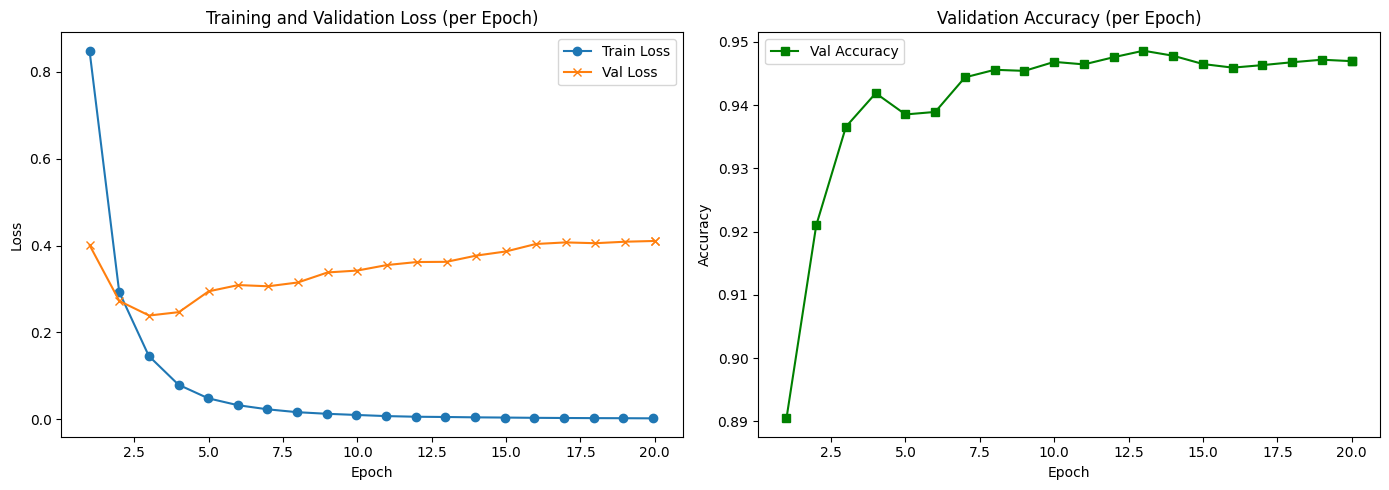

In [35]:
import matplotlib.pyplot as plt

logs = trainer.state.log_history

train_loss = []
train_epochs = []
eval_loss = []
eval_accuracy = []
eval_epochs = []

for entry in logs:
    if "loss" in entry and "epoch" in entry:
        train_loss.append(entry["loss"])
        train_epochs.append(entry["epoch"])
    if "eval_loss" in entry and "epoch" in entry:
        eval_loss.append(entry["eval_loss"])
        eval_epochs.append(entry["epoch"])
    if "eval_accuracy" in entry and "epoch" in entry:
        eval_accuracy.append(entry["eval_accuracy"])

plt.figure(figsize=(14, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_epochs, train_loss, label="Train Loss", marker='o')
plt.plot(eval_epochs, eval_loss, label="Val Loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss (per Epoch)")

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(eval_epochs, eval_accuracy, label="Val Accuracy", color="green", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Validation Accuracy (per Epoch)")

plt.tight_layout()
plt.show()
